#3D Object Detection Method
---------------------------
By : Juan C. Peña and Eberto Benjumea

**(Pending documentation)**

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline
!pip install deeptrack

Mounted at /content/drive


In [4]:
import deeptrack as dt
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.io

In [5]:
data = scipy.io.loadmat('/content/drive/MyDrive/Investigacion/Data/matlab/data2.mat')

In [6]:
input_set = [image for image in data['Spz_pyr'][0]]

In [7]:
scales = [1, 2, 4]

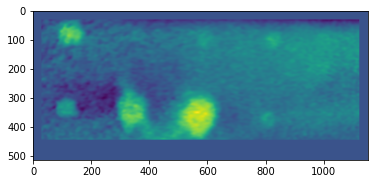

In [8]:
plt.imshow(input_set[0])

In [9]:
normalizating = lambda image : (image - np.min(image)) / (np.max(image) - np.min(image))

In [10]:
normalized_input_set = [normalizating(image) for image in input_set]

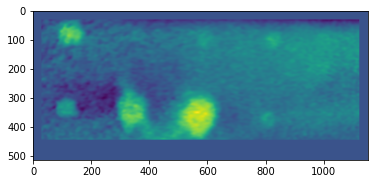

In [11]:
plt.imshow(normalized_input_set[0])

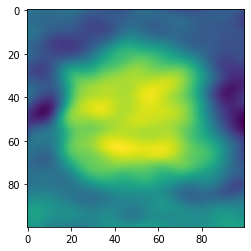

In [12]:
# Cropping
#y, x, w = (325, 760, 100)
y, x, w = (285, 65, 100)
crop = normalized_input_set[0][y:y+w, x:x+w]
plt.imshow(crop)

In [13]:
training_image = np.expand_dims(crop, axis = -1) # Add a third channel

In [14]:
training_image.shape

(100, 100, 1)

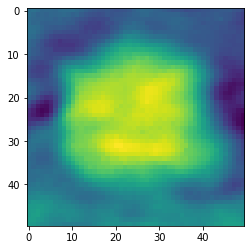

In [80]:
downsample = 2
model = dt.models.LodeSTAR(input_shape=(None, None, 1))

train_set =   (
    dt.Value(training_image)
    >> dt.AveragePooling(ksize=(downsample, downsample, 1)) # Try 1 instead of 3
    #>> dt.Affine(rotate=lambda: np.random.rand()*np.pi*2, scale=lambda:np.random.uniform(1, 2, 2))
    #>> dt.Affine(rotate=lambda: np.random.rand()*np.pi*2, translate=lambda:np.random.uniform(-2, 2, 2))
    >> dt.Add(lambda: np.random.randn() * 0.1) # 0.1
    >> dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.01))  # Very sensitive
    >> dt.Multiply(lambda: np.random.uniform(0.6, 1.2)) #0.3, 1.6
)
#train_set.plot(cmap="gray")
train_set.plot()

In [81]:
history = model.fit(
    train_set,
    epochs=40,
    batch_size=8,
)

Generating 165 / 160 samples before starting training
Epoch 1/40
165/165 [==============================] - 7s 17ms/step - total_loss: 3.0972 - consistency_loss: 1.7590
Epoch 2/40
165/165 [==============================] - 3s 17ms/step - total_loss: 2.8326 - consistency_loss: 1.5839
Epoch 3/40
165/165 [==============================] - 3s 17ms/step - total_loss: 2.3393 - consistency_loss: 1.2337
Epoch 4/40
165/165 [==============================] - 3s 18ms/step - total_loss: 1.2275 - consistency_loss: 0.8590
Epoch 5/40
165/165 [==============================] - 3s 16ms/step - total_loss: 1.0320 - consistency_loss: 0.8077
Epoch 6/40
165/165 [==============================] - 3s 17ms/step - total_loss: 0.9863 - consistency_loss: 0.7998
Epoch 7/40
165/165 [==============================] - 5s 27ms/step - total_loss: 0.9623 - consistency_loss: 0.7630
Epoch 8/40
165/165 [==============================] - 5s 27ms/step - total_loss: 0.9512 - consistency_loss: 0.7686
Epoch 9/40
165/165 [======

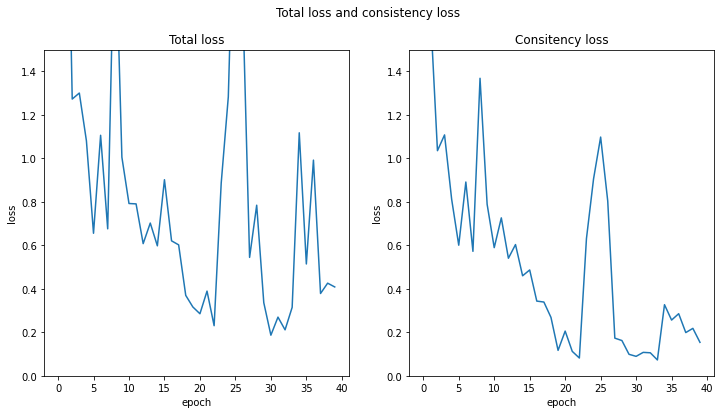

In [82]:
#Summarize history for total_loss and consistency_loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('Total loss and consistency loss')

ax1.plot(history.history['total_loss'])
ax1.set_title('Total loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.set_ylim([0, 1.5])
# ax1.legend(['train', 'test'], loc='upper left')

ax2.plot(history.history['consistency_loss'])
ax2.set_title('Consitency loss')
ax2.set(xlabel='epoch', ylabel='loss')
ax2.set_ylim([0, 1.5])

plt.show()

In [83]:
def detect(image, scale_dif = 1, alpha = 0.1, cutoff = 0.998, mode = "quantile", downsample = 1, s = 2000 * downsample, color = "r"):
  """
  scale_dif -> scale difference between original image and its downsampled version,
  i.e., scale_dif = 2 -> if original image size is the double of its downsampled version.
  """
  aux = image[np.newaxis, :, :, np.newaxis]
  test_image = aux[:, ::downsample * scale_dif, ::downsample * scale_dif, :]

  detections = model.predict_and_detect(test_image, alpha=alpha, beta=1-alpha, cutoff=cutoff, mode="quantile")[0] # -> modes = constant, quantile, ratio
  #detections = model.predict_and_detect(test_image[np.newaxis], alpha=alpha, beta=1-alpha, cutoff=cutoff, mode="quantile")[0]

  detections[:, 1] = detections[:, 1] * downsample * scale_dif
  detections[:, 0] = detections[:, 0] * downsample * scale_dif

  plt.figure(figsize=(15, 15))
  plt.imshow(image)
  #plt.axis("off")
  plt.scatter(detections[:, 1], detections[:, 0], s=s, linewidths=4, facecolors="none", edgecolors=color)

  return detections


1/1 [==============================] - 0s 35ms/step


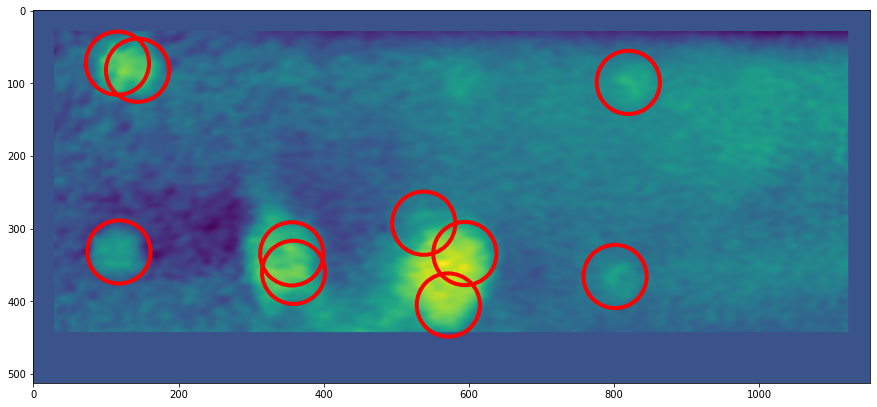

In [168]:
detections1 = detect(image = normalized_input_set[0], scale_dif = scales[0], downsample = downsample, color = "r")

1/1 [==============================] - 0s 23ms/step


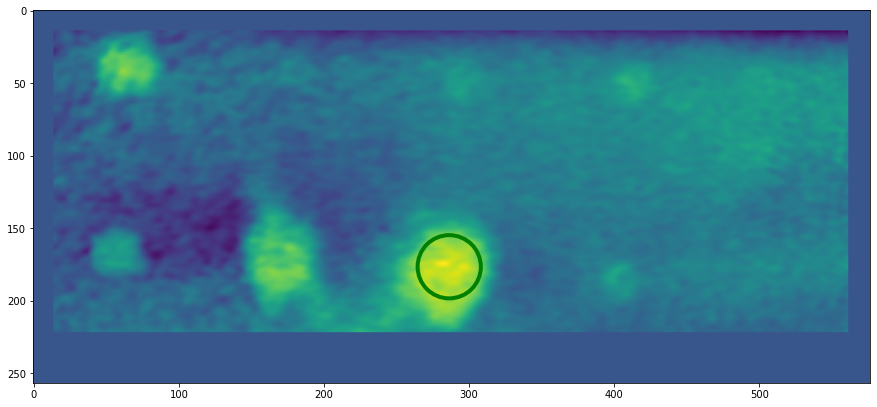

In [169]:
detections2 = detect(image = normalized_input_set[1], scale_dif = scales[1], downsample = 1, color = "g")

1/1 [==============================] - 0s 24ms/step


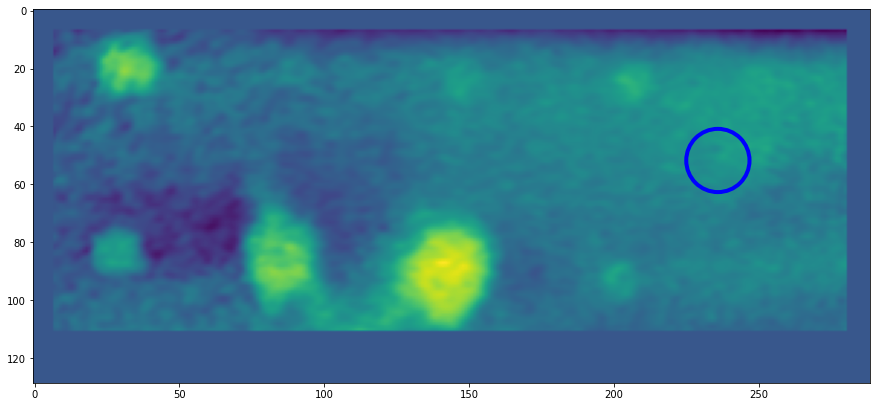

In [170]:
detections3 = detect(image = normalized_input_set[2], scale_dif = scales[2], downsample = 1, color = "b")

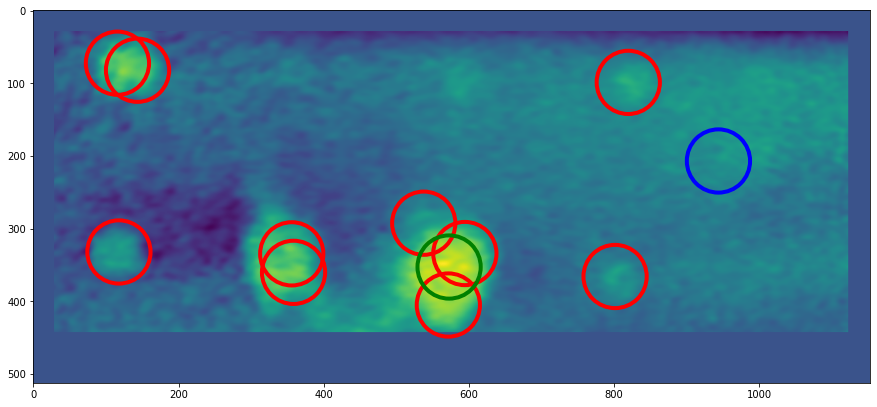

In [171]:
plt.figure(figsize=(15, 15))
plt.imshow(normalized_input_set[0])
#plt.axis("off")

plt.scatter(detections1[:, 1], detections1[:, 0], s=2000 * downsample, linewidths=4, facecolors="none", edgecolors="r")
plt.scatter(detections2[:, 1] * 2, detections2[:, 0] * 2, s=2000 * downsample, linewidths=4, facecolors="none", edgecolors="g")
plt.scatter(detections3[:, 1] * 4, detections3[:, 0] * 4, s=2000 * downsample, linewidths=4, facecolors="none", edgecolors="b")

In [ ]:
!pip install geopandas

In [172]:
d1 = detections1 * scales[0]
d2 = detections2 * scales[1]
d3 = detections3 * scales[2]

d1 = d1.tolist()
d2 = d2.tolist()
d3 = d3.tolist()

dets = d1 + d2 + d3

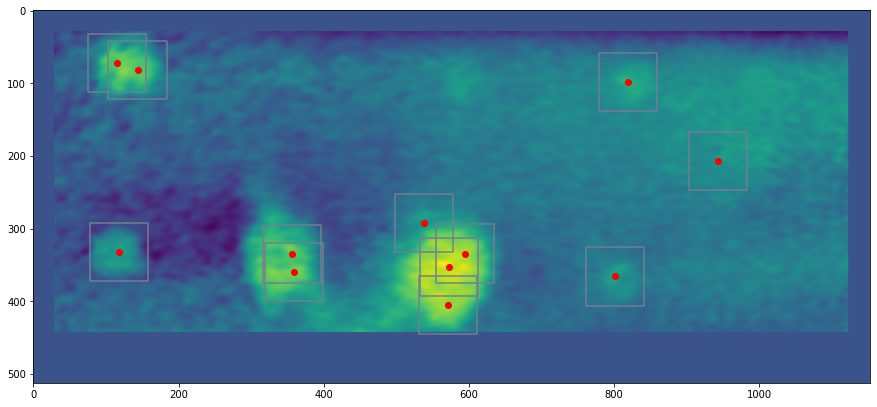

In [176]:
from shapely.geometry import Point
import geopandas as gpd
# Generate some sample data 

list_detections = [Point((x,y)) for (y,x) in dets]

points = gpd.GeoSeries(list_detections)

# Buffer the points using a square cap style
# Note cap_style: round = 1, flat = 2, square = 3
buffer = points.buffer(40, cap_style = 3)

# Plot the results
fig, ax1 = plt.subplots(figsize=(15, 15))
plt.imshow(normalized_input_set[0])
buffer.boundary.plot(ax=ax1, color = 'slategrey')
points.plot(ax = ax1, color = 'red')

In [177]:
boxes = np.array([buffer[index].bounds for index in range(len(buffer))])

In [178]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

In [214]:
overlapThresh = 0.1
final_boxes = non_max_suppression_fast(boxes, overlapThresh = overlapThresh)

In [215]:
len(final_boxes)

8

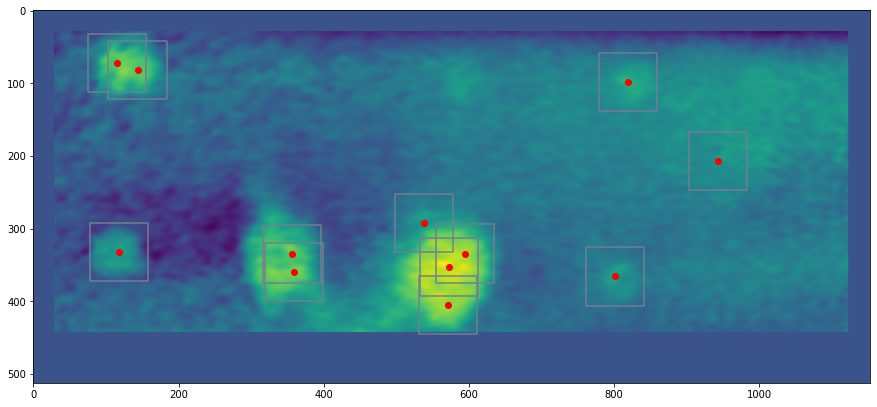

In [199]:
# Image without nms
fig, ax1 = plt.subplots(figsize=(15, 15))
plt.imshow(normalized_input_set[0])
buffer.boundary.plot(ax=ax1, color = 'slategrey')
points.plot(ax = ax1, color = 'red')

In [63]:
from matplotlib.patches import Rectangle

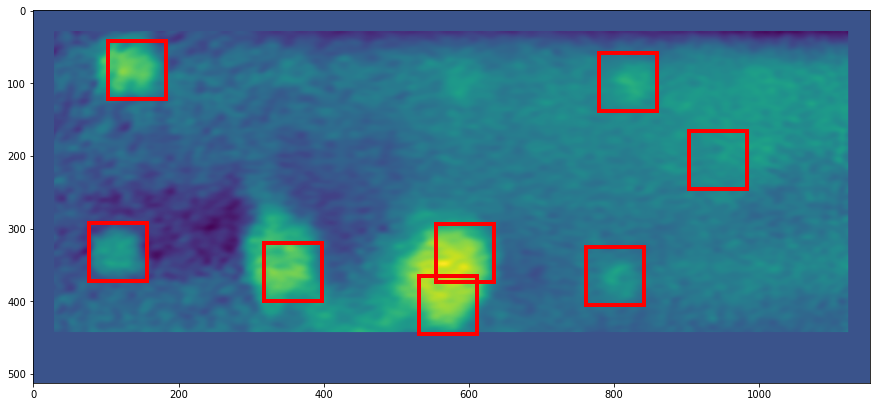

In [216]:
# Image with nms
# Displaying the image 
plt.figure(figsize=(15, 15))
plt.imshow(normalized_input_set[0])

#add rectangles
for i in range(len(final_boxes)):
  plt.gca().add_patch(Rectangle((final_boxes[i][0], final_boxes[i][1]),40*2,40*2,
                                edgecolor='red',
                                facecolor='none',
                                lw=4))